In [1]:
# Paso 0: Importar librerias necesarias

import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import pylab as plt

In [2]:
# Paso 1: Importar el DF de todas las empresas del IBEX 35

df = pd.read_csv('ibex35.csv')

df

,id,ticker,empresa,date,open,high,low,close,adj close,volume
0,1,ANA,Acciona,2019-01-02,73.900002,73.900002,73.900002,73.900002,64.148270,0
1,1,ANA,Acciona,2022-06-24,174.199997,178.800003,174.000000,178.800003,169.562302,0
2,1,ANA,Acciona,2022-06-23,169.899994,173.199997,169.000000,173.000000,164.061951,0
3,1,ANA,Acciona,2022-06-22,171.399994,171.399994,168.800003,170.199997,161.406616,0
4,1,ANA,Acciona,2022-06-21,179.699997,179.699997,172.300003,173.600006,164.630966,0
...,...,...,...,...,...,...,...,...,...,...
44000,35,UNI,Unicaja,2021-03-24,0.802000,0.822000,0.786500,0.819500,0.751219,2616012
44001,35,UNI,Unicaja,2021-03-23,0.770000,0.807500,0.762500,0.802500,0.735636,2436213
44002,35,UNI,Unicaja,2021-03-22,0.780000,0.780500,0.760000,0.764000,0.700343,1420069
44003,35,UNI,Unicaja,2021-03-30,0.867000,0.878500,0.855500,0.877500,0.804387,3028721


In [5]:
# Paso 2: Filtrar por la empresa sobre la que realizar el modelo

acs = df[df['empresa'] == 'Grupo ACS']

acs.shape

(1325, 10)

In [6]:
# Paso 3: Seleccionar las columnas definitivas que utilizaremos

acs = acs [['date','open','high','low','close','adj close']]

acs.shape

(1325, 6)

In [7]:
# Paso 4: Modificar el formato de columna 'date' (format: object ===> datatime)

acs['date'] = pd.to_datetime(acs['date'], format="%Y-%m-%d")

acs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1325 entries, 3325 to 4649
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1325 non-null   datetime64[ns]
 1   open       1325 non-null   float64       
 2   high       1325 non-null   float64       
 3   low        1325 non-null   float64       
 4   close      1325 non-null   float64       
 5   adj close  1325 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 72.5 KB


In [8]:
# Paso 5: Ordenar el DF por fecha

acs.sort_values(by='date',ascending= True, inplace=True)

acs.head()

,date,open,high,low,close,adj close
3987,2019-01-02,33.282990,33.282990,32.245056,32.857929,22.656153
3986,2019-01-03,32.521839,33.243446,32.422989,32.937012,22.710680
3985,2019-01-04,33.312641,33.599312,33.184135,33.431263,23.051476
3984,2019-01-07,33.708046,33.905746,33.243446,33.539997,23.126450
3983,2019-01-08,33.530113,34.231953,33.451035,33.885979,23.365011


In [9]:
# Paso 6: Filtrar nuevamente para eliminar efecto COVID del análisis (previo a 2021)

# Filtro:

fecha_inicio = '2021-07-05'
fecha_fin = '2024-03-01'

acs = acs[(acs['date'] >= fecha_inicio) & (acs['date'] <= fecha_fin)]

# Comprobar si se ha aplicado correctamente

acs.shape

(684, 6)

In [10]:
# Paso 7: Añadir al DF fechas obviadas por mercado de valores español (fin de semana y festivos)

# Rango de fechas desde '2021-01-01' a '2024-03-01'

date_range = pd.date_range(start=acs['date'].min(), end=acs['date'].max(), freq='D')

# Reindexa el DF con el nuevo rango de fechas

acs = acs.set_index('date').reindex(date_range).reset_index()

# Volver a modificar el nombre de columna 'date'

acs = acs.rename(columns={'index': 'date'})

In [11]:
# Paso 8: Comprobar que ha introducido la fechas ausentes en el DF original

acs.head(10)

,date,open,high,low,close,adj close
0,2021-07-05,22.992643,23.061838,22.676321,22.982758,19.462477
1,2021-07-06,22.953102,23.101379,22.547815,22.587357,19.127640
2,2021-07-07,22.735632,22.874022,22.063448,22.063448,18.683979
3,2021-07-08,21.994251,22.043678,21.282528,21.420919,18.139866
4,2021-07-09,21.569195,21.974482,21.470345,21.865747,18.516560
5,2021-07-10,NaN,NaN,NaN,NaN,NaN
6,2021-07-11,NaN,NaN,NaN,NaN,NaN
7,2021-07-12,22.004137,22.231495,21.668045,22.182068,18.784428
8,2021-07-13,22.241379,22.261148,21.944826,22.004137,18.633753
9,2021-07-14,21.915173,22.083218,21.697701,21.865747,18.516560


In [12]:
# Paso 9: Rellenar valores nulos con el anterior valor de la columna(viernes o previo a festivo)

acs = acs.fillna(method='ffill')

In [13]:
# Paso 11: Establecer columna 'date' como índice para modelo

acs = acs.set_index('date')

acs.head(10)

,open,high,low,close,adj close
date,,,,,
2021-07-05,22.992643,23.061838,22.676321,22.982758,19.462477
2021-07-06,22.953102,23.101379,22.547815,22.587357,19.127640
2021-07-07,22.735632,22.874022,22.063448,22.063448,18.683979
2021-07-08,21.994251,22.043678,21.282528,21.420919,18.139866
2021-07-09,21.569195,21.974482,21.470345,21.865747,18.516560
2021-07-10,21.569195,21.974482,21.470345,21.865747,18.516560
2021-07-11,21.569195,21.974482,21.470345,21.865747,18.516560
2021-07-12,22.004137,22.231495,21.668045,22.182068,18.784428
2021-07-13,22.241379,22.261148,21.944826,22.004137,18.633753


In [14]:
# Paso 12: Establecer siguiente criterio para que el modelo AR funcione

acs.index = pd.DatetimeIndex(acs.index).to_period('d')

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

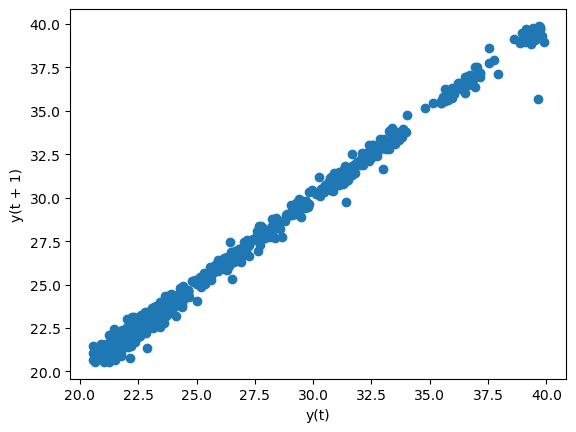

In [15]:
# Paso 13: Comprobar linealidad de la variable y = 'close'

from pandas.plotting import lag_plot

lag_plot(acs.close)

In [16]:
# Paso 14: Importar modelo de AR

from statsmodels.tsa.ar_model import AutoReg as AR

In [17]:
# Paso 15: Realizar el split en el DF del train y el test

train, test = acs.close[:-10], acs.close[-10:]

train.shape, test.shape

((961,), (10,))

In [18]:
# Paso 16: Entrenar el modelo de AR

modelo = AR(train, lags=1).fit()

In [19]:
# Paso 17: Realizar predicción con el entrenamiento

pred = modelo.predict(len(train), len(acs.close)-1)

# Check sobre los valores de la predicción

pred

2024-02-21    36.639932
2024-02-22    36.649859
2024-02-23    36.659781
2024-02-24    36.669699
2024-02-25    36.679612
2024-02-26    36.689521
2024-02-27    36.699425
2024-02-28    36.709325
2024-02-29    36.719221
2024-03-01    36.729112
Freq: D, dtype: float64

In [20]:
# Paso 18: Chequear coincidencia entre test y pred

test

date
2024-02-21    36.730000
2024-02-22    37.070000
2024-02-23    37.160000
2024-02-24    37.160000
2024-02-25    37.160000
2024-02-26    36.939999
2024-02-27    37.529999
2024-02-28    37.770000
2024-02-29    37.939999
2024-03-01    37.130001
Freq: D, Name: close, dtype: float64

In [21]:
# Paso 19: Calcular el error de la predicción sobre la realidad

error = (pred - test).abs().sum()/len(pred)  

error

0.5744511082981184

In [22]:
# Paso 20: Generar un DF sobre la comparativa en realidad, predicción y error

res=pd.DataFrame({'real': test, 'pred': pred, 'error': pred - test})

res

,real,pred,error
2024-02-21,36.730000,36.639932,-0.090068
2024-02-22,37.070000,36.649859,-0.420141
2024-02-23,37.160000,36.659781,-0.500219
2024-02-24,37.160000,36.669699,-0.490301
2024-02-25,37.160000,36.679612,-0.480388
2024-02-26,36.939999,36.689521,-0.250478
2024-02-27,37.529999,36.699425,-0.830574
2024-02-28,37.770000,36.709325,-1.060675
2024-02-29,37.939999,36.719221,-1.220778
2024-03-01,37.130001,36.729112,-0.400889
